# segmentation models, albumentations

In [1]:
#!pip install segmentation-models-pytorch

In [2]:
#!pip install -U git+https://github.com/albu/albumentations --no-cache-dir

## Train

In [3]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from pytorch_lightning import LightningModule, Trainer


import glob
from PIL import Image

In [4]:
PATH_IMAGE =  '../AerialImageDataset/crop/images/'
PATH_MASK =  '../AerialImageDataset/crop/gt/'

list_mask = os.listdir(PATH_MASK)
list_img = os.listdir(PATH_IMAGE)

In [5]:
my_list = list(set(list_mask) & set(list_img))
train, val = train_test_split(my_list, train_size=0.8)
len(train), len(val), len(my_list)

(7056, 1764, 8820)

In [6]:
train[0]

'kitsap8__3000_0.png'

## Dataset

In [7]:
import torch

if not torch.cuda.is_available():
  raise Exception("GPU not availalbe. CPU training will be too slow.")

print("device name", torch.cuda.get_device_name(0))

device name NVIDIA GeForce RTX 3090 Ti


In [8]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset
from torch import nn

In [9]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

In [10]:
class Dataset(BaseDataset):
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    CLASSES = ['unlabelled', 'building']
    
    def __init__(
            self, 
            images_list, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids = images_list
        self.images_fps = [os.path.join(PATH_IMAGE, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(PATH_MASK, image_id) for image_id in self.ids]
        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.ids)

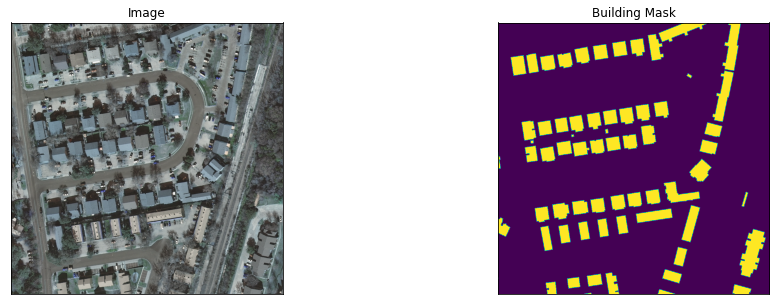

In [11]:
# Lets look at data we have

dataset = Dataset(train, classes=['building'])

image, mask = dataset[6] # get some sample
visualize(
    image=image, 
    building_mask=mask.squeeze(),
)

In [12]:
import albumentations as albu

In [13]:
def get_training_augmentation():
    train_transform = [

        albu.HorizontalFlip(p=0.5),

        albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        albu.PadIfNeeded(min_height=640, min_width=640, always_apply=True, border_mode=0),
        albu.RandomCrop(height=640, width=640, always_apply=True),

        albu.GaussNoise (p=0.2),
        albu.Perspective(p=0.5),

        albu.OneOf(
            [
                albu.CLAHE(p=1),
                albu.RandomBrightness(p=1),
                albu.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.Sharpen(p=1),
                albu.Blur(blur_limit=3, p=1),
                albu.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.RandomBrightnessContrast(p=1),
                albu.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albu.PadIfNeeded(640, 640),
        albu.RandomCrop(height=640, width=640, always_apply=True),
    ]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    if len(x.shape) == 3:
        return x.transpose(2, 0, 1).astype('float32') / 255.
    else:
        return x.astype('float32') / 255.


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

/home/tim/miniconda3/envs/geo/lib/python3.10/site-packages/albumentations/augmentations/transforms.py:1613: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(


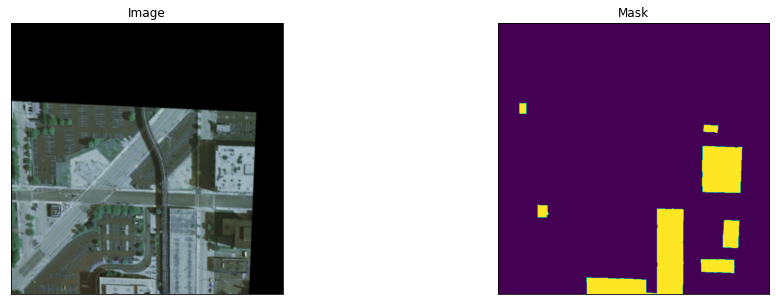

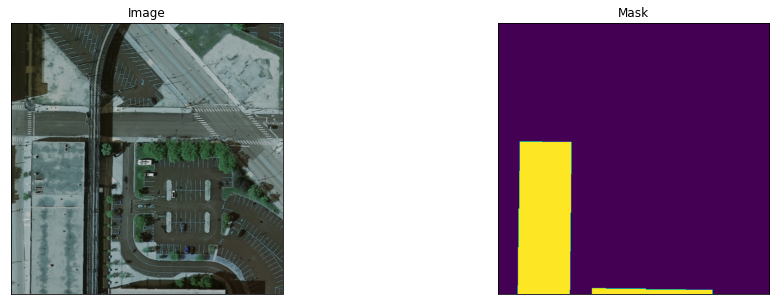

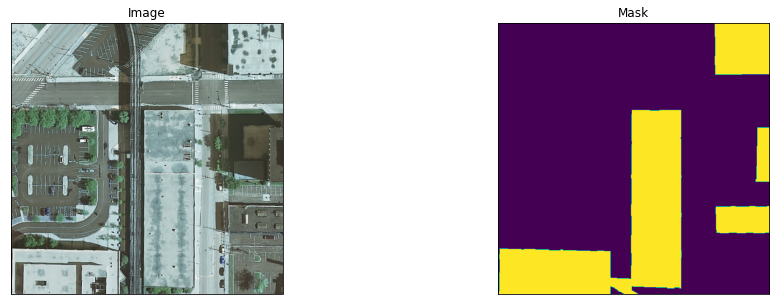

In [14]:
#### Visualize resulted augmented images and masks

augmented_dataset = Dataset(
    train, 
    augmentation=get_training_augmentation(), 
    classes=['building'],
)

# same image with different random transforms
for i in range(3):
    image, mask = augmented_dataset[30]
    #print(image.shape)
    visualize(image=image, mask=mask)

In [15]:
mask.max()

255

In [16]:
import torch
import numpy as np
import segmentation_models_pytorch as smp

In [17]:
ENCODER = 'timm-efficientnet-b5'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['building']
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multicalss segmentation
DEVICE = 'cuda'

model = smp.DeepLabV3Plus(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [18]:
train_dataset = Dataset(
    train, 
    augmentation=get_training_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

valid_dataset = Dataset(
    val, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=8)
valid_loader = DataLoader(valid_dataset, batch_size=4, shuffle=False, num_workers=4)

In [20]:

# Dice/F1 score - https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient
# IoU/Jaccard score - https://en.wikipedia.org/wiki/Jaccard_index

loss = smp.losses.DiceLoss(mode='binary')
optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0001),
])

In [21]:
class SemSegment(LightningModule):
    def __init__(
        self,
        lr: float = 0.001,
        num_classes: int = 1,
        bilinear: bool = False,
    ):
        super().__init__()

        self.bilinear = bilinear
        self.lr = lr
        self.net = model
        self.loss = loss
        self.metric = smp.metrics.iou_score
        self.stats = smp.metrics.get_stats

    def forward(self, x):
        return self.net(x)

    def training_step(self, batch, batch_nb):
        img, mask = batch
        out = self(img.float())
        loss_train_dice = self.loss(out.squeeze(1), mask.float())

        tp, fp, fn, tn = self.stats(out.squeeze(1), mask.detach().int(), mode='binary', threshold=0.5)
        metric = self.metric(tp, fp, fn, tn, reduction="micro")
        # Логи тренировочных шагов для tensorboard
        self.log('train_dice_step', loss_train_dice, on_step=True, )

        return {"loss": loss_train_dice, "log": metric.detach(), "progress_bar": loss_train_dice.detach()}

    def validation_step(self, batch, batch_idx):
        img, mask = batch
        out = self(img.float())
        tp, fp, fn, tn = self.stats(out.squeeze(1), mask.detach().int(), mode='binary', threshold=0.5)
        metric = self.metric(tp, fp, fn, tn, reduction="micro")
        # Логи валидационных шагов для tensorboard
        self.log('val_loss_step', metric, on_step=True)

        return {"val_loss": metric}


    def validation_epoch_end(self, outputs):
        loss_val = torch.stack([x["val_loss"] for x in outputs]).mean()
        log_dict = {"val_loss": loss_val.detach()}
        # Логи валидационных эпох для tensorboard
        self.log('val_epoch_total_step', log_dict['val_loss'], on_epoch=True)

        return log_dict

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.net.parameters(), lr=self.lr)
        scheduler = {
            'scheduler': torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min'),
            'monitor' : 'train_dice_step',
        }
        return {
                "optimizer": optimizer,
                "lr_scheduler": scheduler,
                }


In [22]:
from pytorch_lightning.callbacks import ModelCheckpoint

In [23]:
# model = SemSegment.load_from_checkpoint('lightning_logs/best/epoch=222-step=16501.ckpt')
model = SemSegment()
checkpoint_callback = ModelCheckpoint(dirpath=f"lightning_logs/best_AERIAL_{ENCODER}", save_top_k=2, mode='max', monitor="val_epoch_total_step")

In [24]:
trainer = Trainer(gpus=1,
 max_epochs=100,
 callbacks=[checkpoint_callback]
 )

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(model,
 train_loader, valid_loader,
)

In [26]:
trainer.save_checkpoint("diplab.ckpt")

In [ ]:
torch.save(model, 'last_aerial_1.pt')

In [27]:
images, masks = next(iter(valid_loader))

In [28]:
images.shape, masks.shape

(torch.Size([4, 3, 640, 640]), torch.Size([4, 640, 640]))

In [29]:
output = model(images.to('cuda'))

In [30]:
images.squeeze(0).shape

torch.Size([4, 3, 640, 640])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


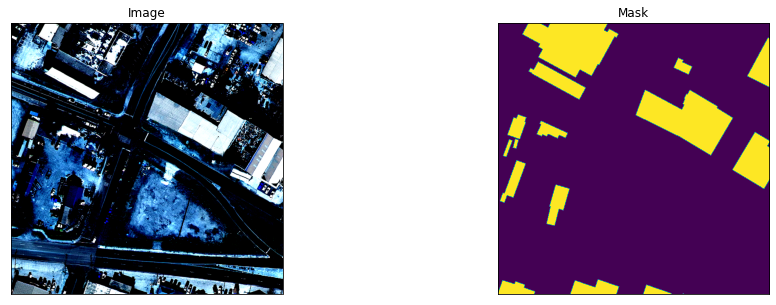

In [32]:
visualize(image=images[0].squeeze(0).permute(1,2,0) * 255, mask=masks[0].squeeze(0)/255.)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


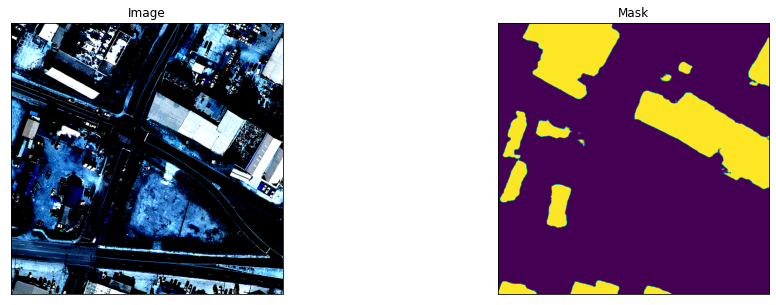

In [34]:
visualize(image=images[0].squeeze(0).permute(1,2,0) * 255, mask=output[0].squeeze().to('cpu').detach().numpy())

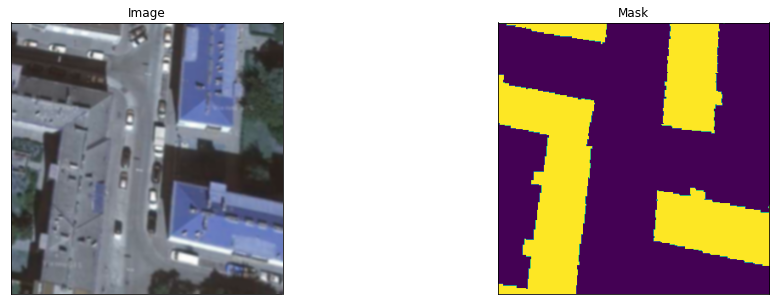

In [54]:
visualize(image=image, mask=mask)

In [55]:
images

tensor([[[[ 1.9693e-03,  2.3051e-03,  1.9693e-03,  ..., -5.8879e-03,
           -5.7536e-03, -3.9404e-03],
          [ 1.9693e-03,  2.2380e-03,  1.9022e-03,  ..., -5.9550e-03,
           -5.5521e-03, -5.8879e-03],
          [ 1.9693e-03,  2.0365e-03,  1.7007e-03,  ..., -6.2908e-03,
           -5.6193e-03, -5.6193e-03],
          ...,
          [-5.8879e-03, -5.8207e-03, -5.8207e-03,  ..., -8.5120e-04,
           -5.8258e-04, -5.8258e-04],
          [-5.8207e-03, -5.8207e-03, -5.7536e-03,  ..., -7.8405e-04,
           -3.8111e-04, -2.4680e-04],
          [-5.7536e-03, -5.8207e-03, -5.8207e-03,  ..., -7.8405e-04,
           -5.8258e-04, -9.1836e-04]],

         [[ 3.2076e-03,  3.5508e-03,  3.2762e-03,  ..., -5.4430e-03,
           -5.2370e-03, -2.9027e-03],
          [ 3.3449e-03,  3.4135e-03,  3.2762e-03,  ..., -5.4430e-03,
           -5.1683e-03, -5.3057e-03],
          [ 3.2762e-03,  3.2762e-03,  3.1389e-03,  ..., -5.5803e-03,
           -4.8251e-03, -4.9624e-03],
          ...,
     